# Goal 

## The goal of this notebook is to tell a story of the air quality till the year 2019 and in 2020. We all know that 2020 has not started well but due to lockdown in many countries, how the pandemic has played a role in the air quality.

### Questions I want to address are:

1.) What was the average AQI before and in 2020 in each country? <br>
2.) What was the highest occuring pollutant in top 5 country before and in 2020?<br>
3.) Correlation between country and pollutants?<br>
4.) Which month has the most AQI overall?<br>


In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import folium
import folium.plugins as plugins

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows =10
%matplotlib inline

***Air Quality Index(AQI)*  **

The AQI is an index for reporting daily air quality. It tells
you how clean or unhealthy your air is, and what associated health effects might be a concern

In [2]:
# customized query helper function in Kaggle
import bq_helper

# Helper object
openaq = bq_helper.BigQueryHelper(active_project='bigquery-public-data',
                                 dataset_name='openaq')
# List of table
openaq.list_tables()

Using Kaggle's public dataset BigQuery integration.


['global_air_quality']

In [3]:
# Table Schema

openaq.table_schema('global_air_quality')

,name,type,mode,description
0,location,STRING,NULLABLE,Location where data was measured
1,city,STRING,NULLABLE,City containing location
2,country,STRING,NULLABLE,Country containing measurement in 2 letter ISO...
3,pollutant,STRING,NULLABLE,Name of the Pollutant being measured. Allowed ...
4,value,FLOAT,NULLABLE,Latest measured value for the pollutant
...,...,...,...,...
6,unit,STRING,NULLABLE,The unit the value was measured in coded by UC...
7,source_name,STRING,NULLABLE,Name of the source of the data
8,latitude,FLOAT,NULLABLE,Latitude in decimal degrees. Precision >3 deci...
9,longitude,FLOAT,NULLABLE,Longitude in decimal degrees. Precision >3 dec...


In [4]:
openaq.head('global_air_quality')

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


In [5]:
query = """ SELECT value,country, pollutant, 
extract(year from timestamp) as year,
extract(month from timestamp) as month,
extract(day from timestamp) as day,
date(timestamp) as date, unit
from `bigquery-public-data.openaq.global_air_quality`
"""

df1 = openaq.query_to_pandas(query)
df1

,value,country,pollutant,year,month,day,date,unit
0,910.00,IN,co,2018,2,22,2018-02-22,µg/m³
1,131.87,IN,no2,2018,2,22,2018-02-22,µg/m³
2,15.57,IN,o3,2018,2,22,2018-02-22,µg/m³
3,45.62,IN,pm25,2018,2,22,2018-02-22,µg/m³
4,4.49,IN,so2,2018,2,22,2018-02-22,µg/m³
...,...,...,...,...,...,...,...,...
21244,65.00,ES,pm10,2020,5,23,2020-05-23,µg/m³
21245,22.00,ES,pm25,2020,5,23,2020-05-23,µg/m³
21246,15.00,ES,so2,2020,5,23,2020-05-23,µg/m³
21247,62.00,ES,o3,2020,5,31,2020-05-31,µg/m³


In [6]:
df1['unit'].value_counts()

µg/m³    17699
ppm       3550
Name: unit, dtype: int64

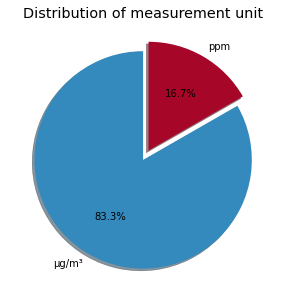

In [7]:
query = """SELECT  unit,COUNT(unit) as `count`
        FROM `bigquery-public-data.openaq.global_air_quality`
        GROUP BY unit
        """
unit = openaq.query_to_pandas(query)

plt.style.use('bmh')
f, ax1 = plt.subplots(figsize = (14,5))

ax1.pie(x=unit['count'],labels=unit['unit'],shadow=True,autopct='%1.1f%%',explode=[0,0.1],\
       startangle=90,)
ax1.set_title('Distribution of measurement unit')
explode = np.arange(0,0.1)

## Majority of them uses unit = micro gram per meter cube.

In [8]:
df1['year'].value_counts()

2020    16477
2018     1808
2017     1286
2019     1004
2016      616
2015       30
2007       12
2008       10
2014        4
2028        2
Name: year, dtype: int64

### So there is an error while recording the year as 2028 isn't possible. Therefore, removing/ignoring that year would be the way to go.

## Average AQI per country

In [9]:
## cols: country, value, year
## year < 2020 
## value > 0
## unit = 'µg/m³'

query = """ select country, round(avg(value)) as avg_value
            from `bigquery-public-data.openaq.global_air_quality`
            where unit ='µg/m³' and extract(year from timestamp) < 2020 
            group by country
            having avg_value > 0 
            order by avg_value desc"""

before = openaq.query_to_pandas(query)
before.head(10)

,country,avg_value
0,CL,5242.0
1,IN,866.0
2,SG,283.0
3,IT,245.0
4,MK,229.0
5,ES,195.0
6,PL,151.0
7,CN,151.0
8,RU,134.0
9,PE,128.0


In [10]:
# stats
before['avg_value'].describe()

count      50.000000
mean      175.980000
std       743.123317
min         2.000000
25%        13.000000
50%        24.500000
75%        95.250000
max      5242.000000
Name: avg_value, dtype: float64

Text(0, 0.5, 'Average AQI in $ug/m^3$')

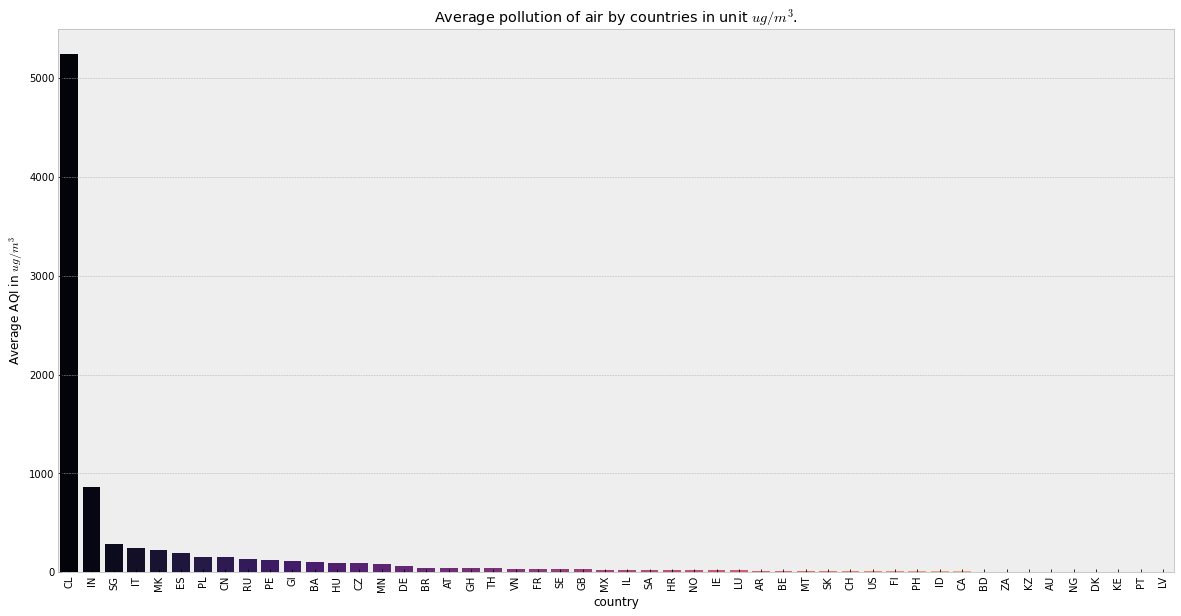

In [11]:
plt.style.use('bmh')
plt.figure(figsize = (20,10))
sns.barplot(before['country'], before['avg_value'], palette = 'magma')
plt.xticks(rotation  = 90)
plt.title('Average pollution of air by countries in unit $ug/m^3$.')
plt.ylabel('Average AQI in $ug/m^3$')

It seems like Chile (CL) is definitely an outlier and have to look closer to it's values. <br>
Rest India(IN), Singapore(SG), Italy (IT), Spain (ES) are in top 5 with worst average AQI. 

In [12]:
query = """ 
select city, value,extract( year from timestamp) as year, extract(month from timestamp) as month 
from `bigquery-public-data.openaq.global_air_quality`
where country = 'CL'and extract( year from timestamp) = 2019
"""

cl = openaq.query_to_pandas(query)
print(cl)
print(cl.describe())

            city      value  year  month
0   Escuela E-10  825736.00  2019      7
1   Escuela E-10       1.97  2019      7
2   Escuela E-10      26.37  2019      7
3   Escuela E-10      45.66  2019      7
4   Escuela E-10      24.74  2019      7
..           ...        ...   ...    ...
8       El Sauce      18.30  2019      8
9     QUILICURA      142.00  2019      8
10    QUILICURA       49.00  2019      8
11     Talagante     134.80  2019     12
12     Talagante       0.00  2019      8

[13 rows x 4 columns]
               value    year      month
count      13.000000    13.0  13.000000
mean    63552.720000  2019.0   7.000000
std    229007.579811     0.0   2.483277
min         0.000000  2019.0   1.000000
25%         2.580000  2019.0   7.000000
50%        24.740000  2019.0   7.000000
75%        49.000000  2019.0   8.000000
max    825736.000000  2019.0  12.000000


Clearly we see that there is an error in getting the value on month 7 i.e july of 2019. Removing that value will help us to understand the overall situation of CL properly.


In [13]:
query = """ select country, round(avg(value)) as avg_value
            from `bigquery-public-data.openaq.global_air_quality`
            where unit ='µg/m³' and extract(year from timestamp) < 2020
            and value > 0 AND value < 10000
            -- value > 100000 to be considered as outliers
            group by country
            order by avg_value DESC"""

before = openaq.query_to_pandas(query)
before

,country,avg_value
0,IT,467.0
1,SG,283.0
2,IN,263.0
3,CL,237.0
4,MK,229.0
...,...,...
47,ZA,6.0
48,KZ,6.0
49,AU,6.0
50,NG,4.0


Text(0, 0.5, 'Average AQI in $ug/m^3$')

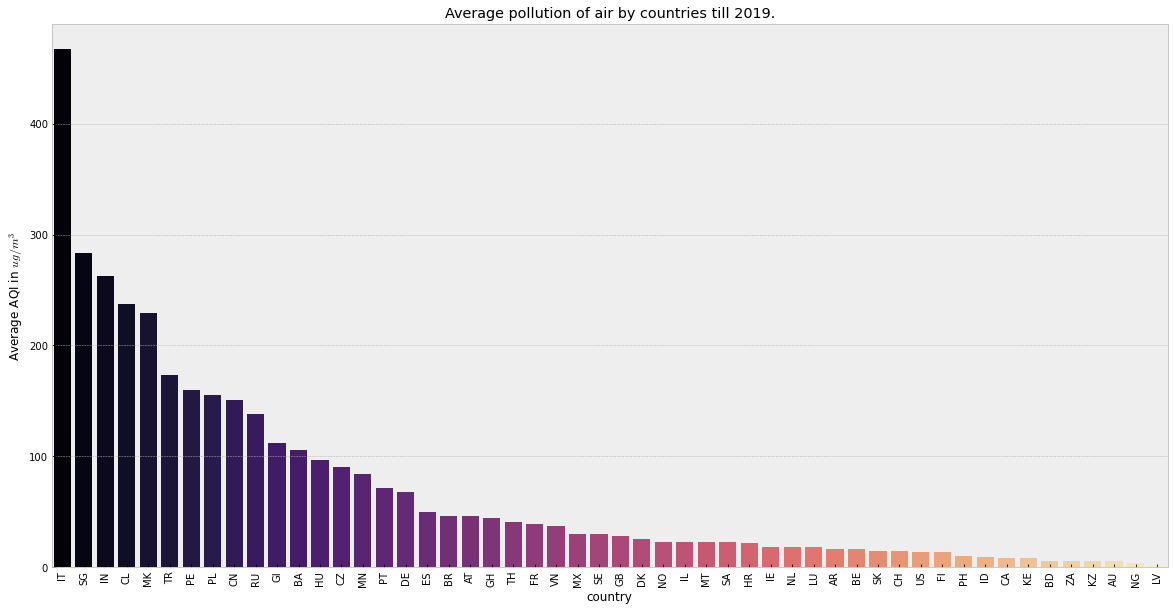

In [14]:
# PLOT
plt.figure(figsize = (20,10))
sns.barplot(before['country'], before['avg_value'], palette ='magma')
plt.xticks(rotation  = 90)
plt.title('Average pollution of air by countries till 2019.')
plt.ylabel('Average AQI in $ug/m^3$')

Top 5 pollutors of air - <br>
Italy (IT), Singapore(SG),India(IN), Chile(CL) and Macedonia (MK)

Least 5 pollutors of air - <br>
Latavia(LV), Nigeria (NG), Australia (AU), South Africa(ZA) and Kazakshtan(KZ)

Countries might to change if ran after sometimes due to update in data.

# In 2020

In [15]:
query = """ 
select distinct country, extract(year from timestamp) as year,round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
group by country, year
having year = 2020 and avg_value > 0
order by avg_value desc
"""

in_2020 = openaq.query_to_pandas(query)
in_2020

,country,year,avg_value
0,BA,2020,284.0
1,IN,2020,168.0
2,CN,2020,164.0
3,PE,2020,162.0
4,CL,2020,137.0
...,...,...,...
76,ZA,2020,5.0
77,US,2020,3.0
78,CW,2020,3.0
79,BM,2020,2.0


Text(0, 0.5, 'Average AQI in $ug/m^3$')

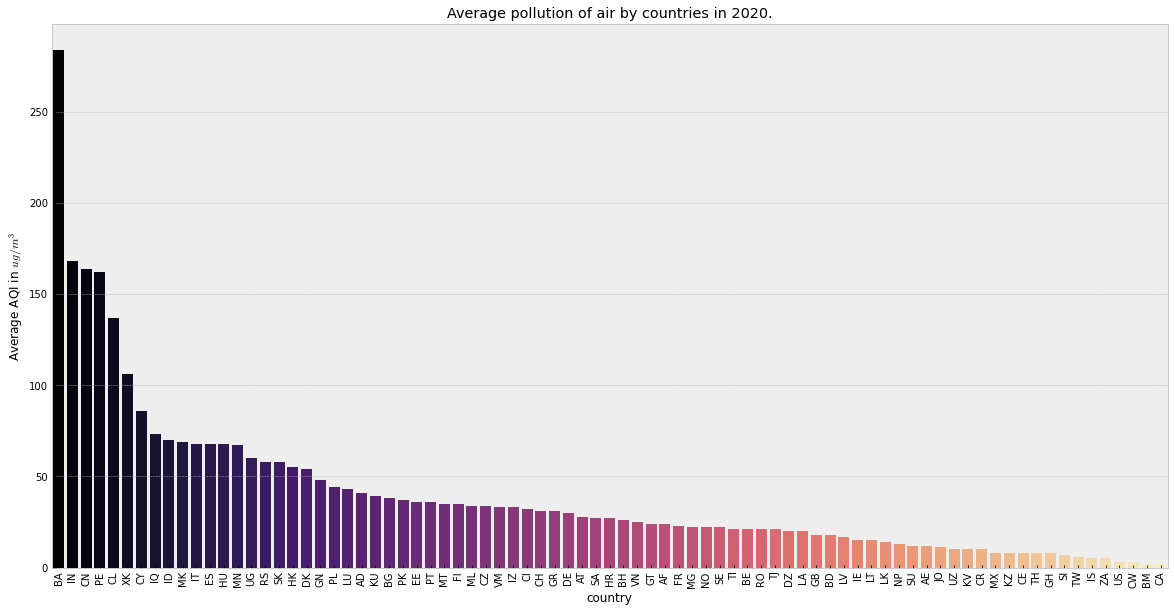

In [16]:

# PLOT
#plt.style.use('bmh')
plt.figure(figsize = (20,10))
sns.barplot(in_2020['country'], in_2020['avg_value'], palette ='magma')
plt.xticks(rotation  = 90)
plt.title('Average pollution of air by countries in 2020.')
plt.ylabel('Average AQI in $ug/m^3$')

We see in 2020 Bosnia and Herzegovina(BA) is the most CO polluant country where as the other top 5 till 2019, their avg value has become low.
It signifies that Lockdown had a huge effect on these countries

  country  till_2019  in_2020
1      IN      263.0    168.0
  country  till_2019  in_2020
0      IT      467.0     68.0
   country  till_2019  in_2020
14      AT       46.0     28.0


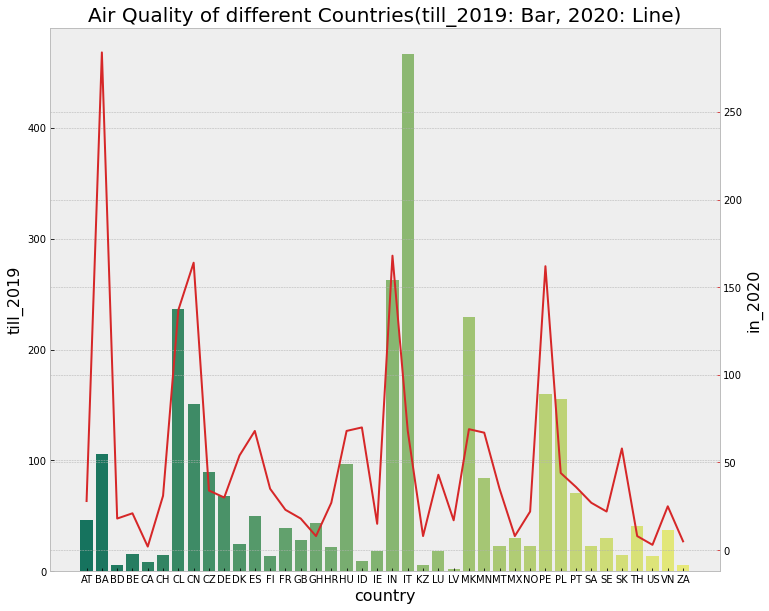

In [17]:
## Trying to combine two different graphs with 

combined = pd.merge(before, in_2020, how = 'inner', on ='country')
combined.rename(columns = {'avg_value_x': 'till_2019', 'avg_value_y' : 'in_2020'}, inplace = True)
combined.drop('year', axis = 1, inplace =True)
print(combined[combined['country'] == 'IN'])
print(combined[combined['country'] == 'IT'])
print(combined[combined['country'] == 'AT'])
combined.sort_values(by = 'country', inplace = True)


fig, ax1 = plt.subplots(figsize = (12,10))
color = 'tab:green'
#barplot
ax1.set_title('Air Quality of different Countries(till_2019: Bar, 2020: Line)', fontsize = 20)
ax1.set_ylabel('AQI till 2019', fontsize =16)
ax1.set_xlabel('Countries', fontsize =16)
ax1 = sns.barplot(x = 'country', y = 'till_2019', data = combined, palette = 'summer')
ax1.tick_params(axis = 'y')

#lineplot
ax2 = ax1.twinx()
color ='tab:red'
ax2.set_ylabel('AQI in 2020', fontsize =16)
ax2 = sns.lineplot(x = 'country', y = 'in_2020', data = combined, color = color)
ax2.tick_params(axis = 'y', color =color)

### We observe that the max avg_value has dropped down from 467 to 297 approx 50% reduction
### Though India remains in 3rd position but the avg AQI has seen a drop from 263 to 154 approx 41% reduction.

## Major change we can see in the countries like BA, IT, PE which has tremendous affect in 2020.

# Pollutant in top 5 countries till 2019

In [18]:
## POLLUTANT IN TOP 5 POLLUTING COUNTRY till 2019
## used SUBQUERY to make FIG dynamic as the top 5 countries might change due to update of data.

query = """ 
select country, pollutant,round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality` 
where country in (select country from `bigquery-public-data.openaq.global_air_quality` 
                  where value > 0 and value < 10000 and unit  = 'µg/m³'and extract(year from timestamp) < 2020
                  group by country
                  order by avg(value) desc 
                  limit 5) and value > 0 and value < 10000 and unit  = 'µg/m³'
and extract(year from timestamp)  < 2020
group by country, pollutant
"""

top = openaq.query_to_pandas(query)
top


,country,pollutant,avg_value
0,IN,co,1149.0
1,IN,no2,60.0
2,IN,o3,37.0
3,IN,pm25,110.0
4,IN,so2,16.0
...,...,...,...
16,CL,co,1397.0
17,MK,pm10,25.0
18,IT,co,1000.0
19,IT,no2,31.0


In [19]:
pivot = top.pivot(index = 'country',columns = 'pollutant', values = 'avg_value')
pivot = pivot.fillna(0)
pivot

pollutant,co,no2,o3,pm10,pm25,so2
country,,,,,,
CL,1397.0,33.0,197.0,42.0,34.0,32.0
IN,1149.0,60.0,37.0,225.0,110.0,16.0
IT,1000.0,31.0,0.0,49.0,0.0,0.0
MK,728.0,30.0,33.0,25.0,0.0,27.0
SG,0.0,0.0,0.0,0.0,283.0,0.0


Text(0.5, 1.0, 'Distirbution of Pollutants in Top 5 Countries till 2019')

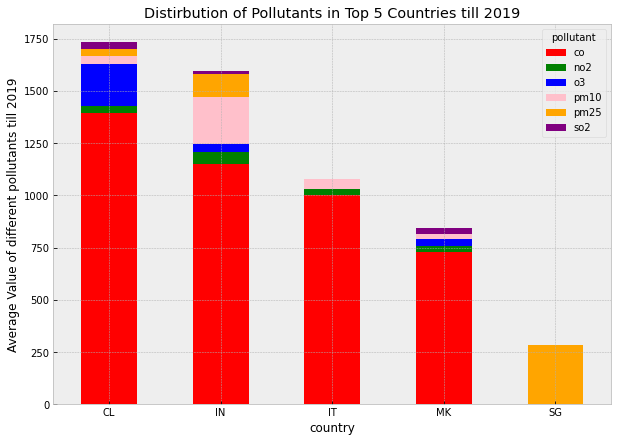

In [20]:
pivot.plot.bar(stacked = True, color = ['red','green','blue','pink','orange','purple'], figsize = (10,7))
plt.xticks(rotation = 360)
plt.ylabel('Average Value of different pollutants till 2019')
plt.title('Distirbution of Pollutants in Top 5 Countries till 2019')

#### Type of emissions most done:

CO, O3, SO2 - Chile(CL)<br>
NO2, pm10 - India(IN)<br>
pm25 - Singapore(SG)<br>

Seems like SG has atleast one NA value in each field or no values at all.<br>
Let's look into SG value

In [21]:
query = """ select country, pollutant, value
from `bigquery-public-data.openaq.global_air_quality`
where country = 'SG'"""

sg = openaq.query_to_pandas(query)
sg

,country,pollutant,value
0,SG,pm25,282.9


So our assumption regarding SG was true as it has only one pollutant value.

Text(0.5, 1.0, 'Distirbution of Pollutants in Top 5 Countries in 2020')

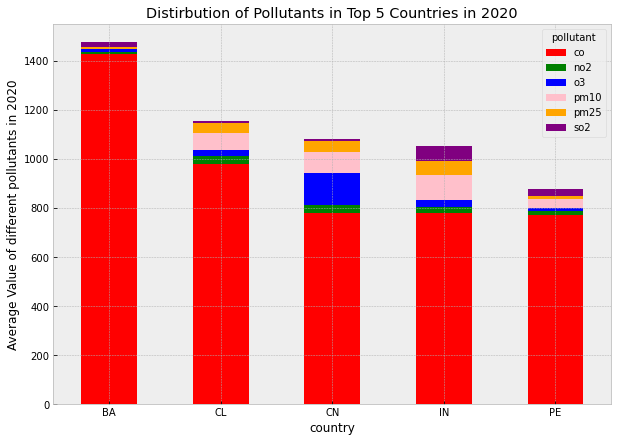

In [22]:
## pollutant in 2020
## used SUBQUERY to make my FIG dynamic as the top 5 countries get changed.

query = """ 
select country, pollutant,round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality` 
where country in (select country from `bigquery-public-data.openaq.global_air_quality` 
                  where value > 0 and value < 10000 and unit  = 'µg/m³'and extract(year from timestamp)  = 2020
                  group by country
                  order by avg(value) desc 
                  limit 5) and value > 0 and value < 10000 and unit  = 'µg/m³'
                
and extract(year from timestamp)  = 2020
group by country, pollutant
"""

top_2020 = openaq.query_to_pandas(query)
#print(top_2020)


pivot_2020 = top_2020.pivot(index = 'country',columns = 'pollutant', values = 'avg_value')
pivot_2020 = pivot_2020.fillna(0)
#print(pivot_2020)

pivot_2020.plot.bar(stacked = True, color = ['red','green','blue','pink','orange','purple'], figsize = (10,7))
plt.xticks(rotation = 360)
plt.ylabel('Average Value of different pollutants in 2020')
plt.title('Distirbution of Pollutants in Top 5 Countries in 2020')

# Correlation of Pollutants and Country till 2019 and in 2020

### Till 2019

In [23]:
query = """ 
select country, pollutant,round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value >0 and value < 10000 and extract(year from timestamp) < 2020
group by country, pollutant
order by avg_value desc

"""

cor_before = openaq.query_to_pandas(query)
cor_before

,country,pollutant,avg_value
0,PE,co,1431.0
1,CL,co,1397.0
2,IN,co,1149.0
3,TR,co,1045.0
4,IT,co,1000.0
...,...,...,...
166,PL,bc,1.0
167,HR,pm25,1.0
168,US,bc,0.0
169,FI,so2,0.0


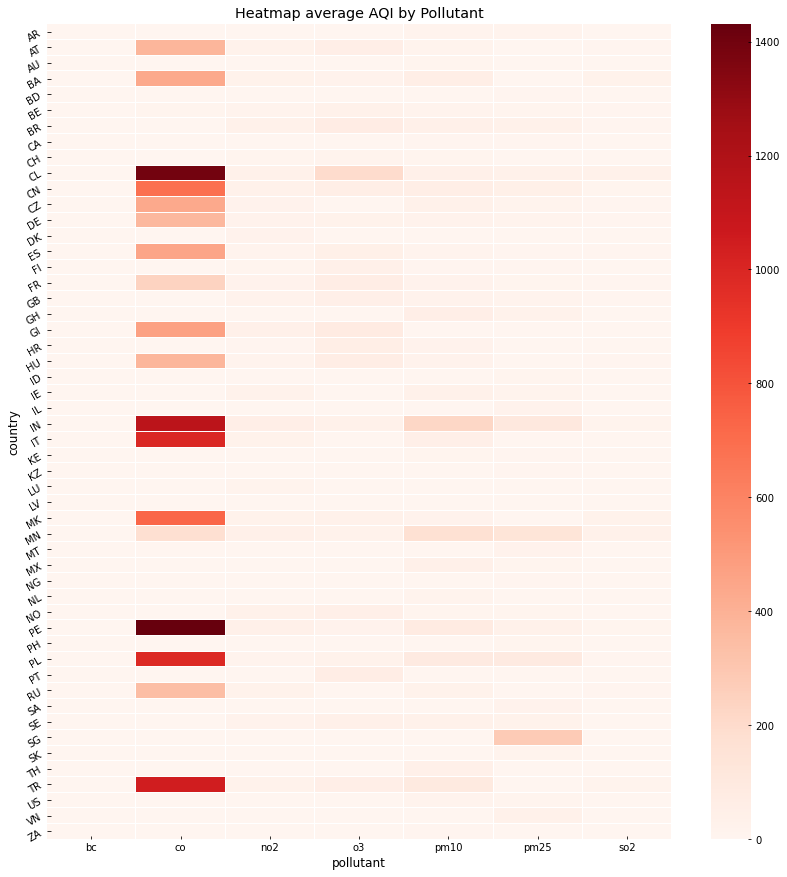

In [24]:
# By country
p1_pivot = cor_before.pivot(index = 'country',values='avg_value', columns= 'pollutant')
p1_pivot = p1_pivot.fillna(0)
plt.figure(figsize=(14,15))
ax = sns.heatmap(p1_pivot, lw=0.01, cmap=sns.color_palette('Reds',500))
plt.yticks(rotation=30)
plt.title('Heatmap average AQI by Pollutant');

It is seen that CL, PE, IN, TR, PL are major pollutant of CO till **2019**

### In 2020

In [25]:
query = """ 
select country, pollutant,round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value >0 and value < 10000 and extract(year from timestamp) = 2020
group by country, pollutant
order by avg_value desc

"""

cor_2020 = openaq.query_to_pandas(query)
cor_2020

,country,pollutant,avg_value
0,BA,co,1427.0
1,CL,co,980.0
2,IN,co,781.0
3,CN,co,780.0
4,PE,co,772.0
...,...,...,...
275,IE,co,0.0
276,NL,co,0.0
277,LT,co,0.0
278,LU,so2,0.0


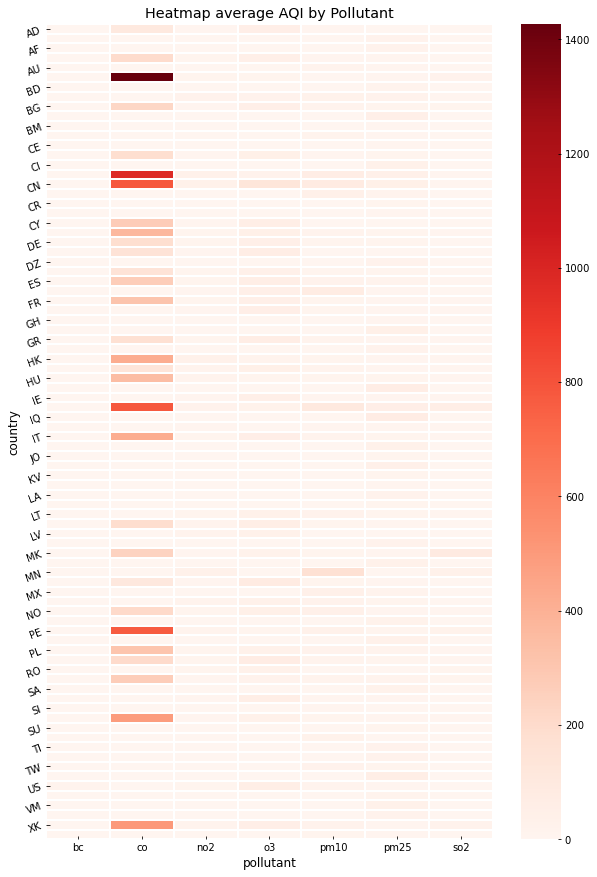

In [26]:
# By country
p2_pivot = cor_2020.pivot(index = 'country',values='avg_value', columns= 'pollutant')
p2_pivot = p2_pivot.fillna(0)
plt.figure(figsize=(10,15))
ax = sns.heatmap(p2_pivot, lw=1, cmap=sns.color_palette('Reds',500))
plt.yticks(rotation=20)
plt.title('Heatmap average AQI by Pollutant');

# AQI distirbution by month

### Till 2019

In [27]:
query = """ 
select extract(month from timestamp) as months, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value < 10000 and extract(year from timestamp) < 2020
group by months
order by months

"""


month =openaq.query_to_pandas(query)
month

,months,avg_value
0,1,142.0
1,2,203.0
2,3,57.0
3,4,99.0
4,5,62.0
...,...,...
7,8,117.0
8,9,109.0
9,10,106.0
10,11,119.0


Text(0.5, 1.0, 'Average value of AQI per month till 2019')

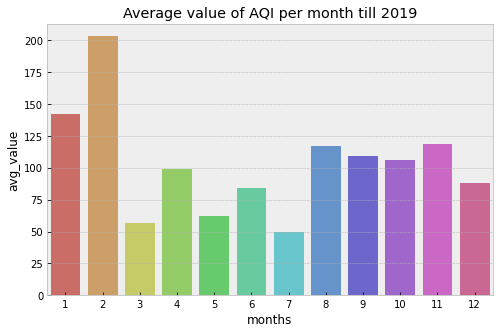

In [28]:
plt.figure(figsize = (8,5))
sns.barplot(month['months'], month['avg_value'], palette = 'hls')
plt.title('Average value of AQI per month till 2019')

### In 2020

In [29]:
query = """ 
select extract(month from timestamp) as months, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value < 10000 and extract(year from timestamp) = 2020
group by months
order by months

"""


month_2020 =openaq.query_to_pandas(query)
month_2020

,months,avg_value
0,1,84.0
1,2,53.0
2,3,63.0
3,4,71.0
4,5,58.0
5,6,51.0


Text(0.5, 1.0, 'Average value of AQI per month in 2020')

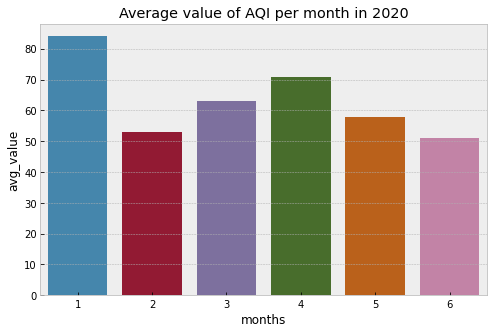

In [30]:
plt.figure(figsize = (8,5))
sns.barplot(month_2020['months'], month_2020['avg_value'])
plt.title('Average value of AQI per month in 2020')

### From both images we see that the overall avg value of AQI has been tremendously reduce in the month of February 2020 (75%)

# Location

### Till 2019

In [31]:
## Before 2020

query = """ 

select country,city, latitude, longitude, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000 and extract(year from timestamp) < 2020
group by country, city, latitude, longitude
order by avg_value desc
"""

cities_before = openaq.query_to_pandas(query)
cities_before.dropna(inplace =True)
cities_before.head(10)

,country,city,latitude,longitude,avg_value
0,ES,Salamanca,40.979168,-5.665278,4800.0
1,TR,Muğla,37.311210,27.782932,1872.0
2,TR,Kocaeli,40.788730,29.537188,1455.0
3,IT,FORLI',44.216000,12.057500,1400.0
4,CL,Coronel,-36.983803,-73.159775,1279.0
5,IT,PARMA,44.786600,10.336500,1200.0
6,IT,FIORANO MODENESE,44.542200,10.819900,1100.0
7,IN,Chennai,12.997114,80.191510,1092.0
8,IT,IMOLA,44.355400,11.720700,1000.0
9,IT,FERRARA,44.842500,11.613100,1000.0


In [32]:
#Italy avg value

print('The average AQI for Italy till 2019 was {}'.format(round(cities_before[cities_before['country'] == 'IT']['avg_value'].mean(),2)))

The average AQI for Italy till 2019 was 607.33


In [33]:
## after

query = """ 

select country,city, avg(latitude) as latitudes, avg(longitude) as longitudes, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000 and extract(year from timestamp) = 2020
group by country, city
order by avg_value desc
"""

cities_after = openaq.query_to_pandas(query)
cities_after.dropna(inplace = True)
cities_after.head(10)



,country,city,latitudes,longitudes,avg_value
0,IN,Nandesari,22.410803,73.09792,1474.0
1,IN,Kalyan,19.252920,73.14202,1321.0
2,IN,Bagalkot,16.172806,75.65969,1286.0
3,IN,Loni Dehat,28.757294,77.27879,956.0
4,CL,El Bosque,-33.547100,-70.66621,664.0
5,IN,Ernakulam,9.985653,76.28134,629.0
6,CL,Nacimiento,-37.508938,-72.65609,625.0
7,CL,Junta de Vecinos,-32.935165,-71.52577,574.0
8,CL,Cerro Navia,-33.433090,-70.73215,561.0
9,IN,Chennai,13.164544,80.26285,526.0


In [34]:
#Italy avg_value

print('The average AQI for Italy in 2020 is {}'.format(round(cities_before[cities_after['country'] == 'IT']['avg_value'].mean(),2)))

The average AQI for Italy in 2020 is 85.24


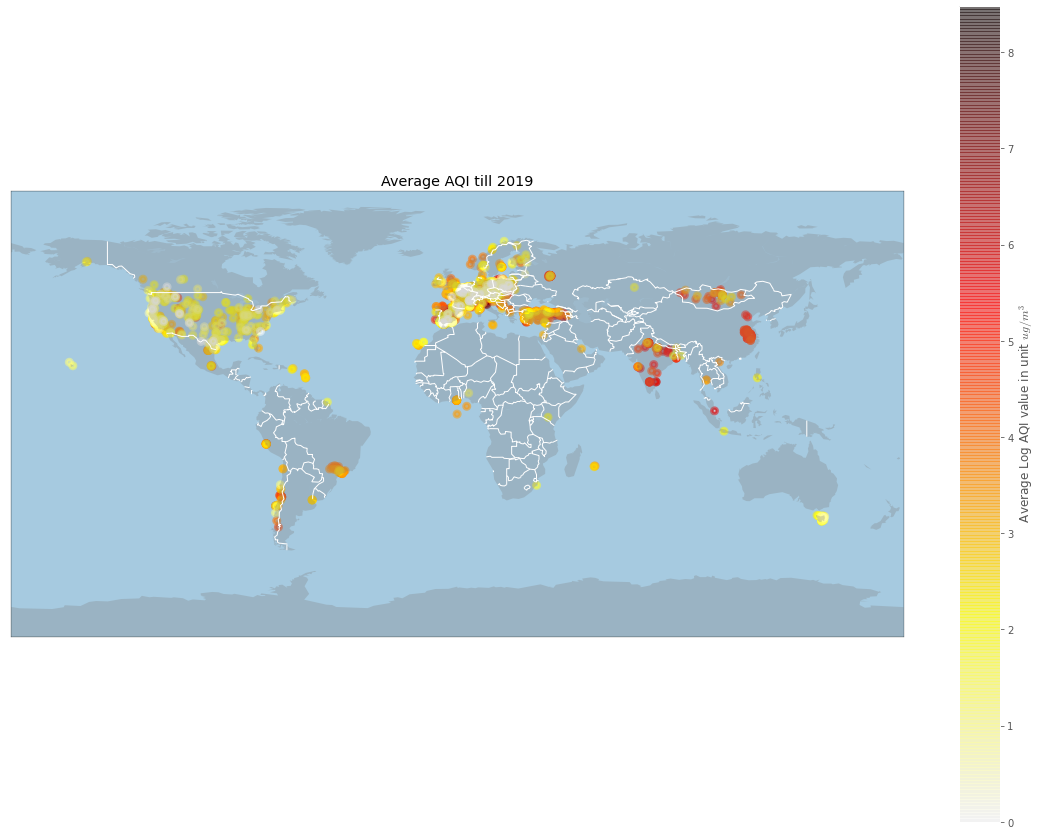

In [35]:
plt.style.use('ggplot')
f,ax =plt.subplots(figsize = (20,15))
m1 = Basemap(projection = 'cyl', llcrnrlon = -180, urcrnrlon =180, llcrnrlat =-90, urcrnrlat = 90,
            resolution = 'c', lat_ts= True)
m1.drawmapboundary(fill_color = '#A6CAE0', linewidth =0.2)
m1.fillcontinents(color ='grey', alpha =0.3)
m1.drawcountries(linewidth = 1, color = 'white')
m1.shadedrelief()

avg = np.log(cities_before['avg_value'])
m1loc =m1(cities_before['latitude'].tolist(), cities_before['longitude'])
m1.scatter(m1loc[1],m1loc[0],lw = 3, alpha =0.5, cmap ='hot_r', c =avg)
plt.title('Average AQI till 2019')
plt.colorbar(label=' Average Log AQI value in unit $ug/m^3$')
#Basemap?


### We can see that USA, AU has the best quality of air.
### Whereas IT, IN, China has the worst AQI.

# In 2020

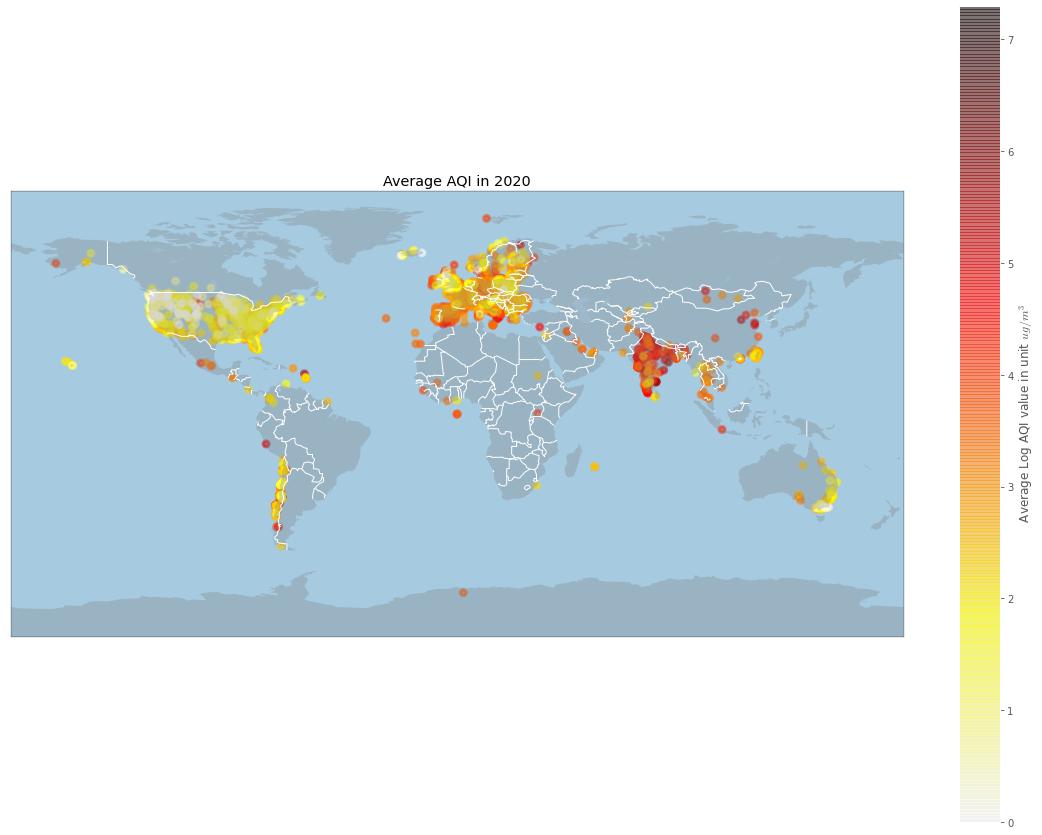

In [36]:
plt.style.use('ggplot')
f,ax =plt.subplots(figsize = (20,15))
m1 = Basemap(projection = 'cyl', llcrnrlon = -180, urcrnrlon =180, llcrnrlat =-90, urcrnrlat = 90,
            resolution = 'c', lat_ts= True)
m1.drawmapboundary(fill_color = '#A6CAE0', linewidth =0.2)
m1.fillcontinents(color ='grey', alpha =0.3)
m1.drawcountries(linewidth = 1, color = 'white')
m1.shadedrelief()

avg = np.log(cities_after['avg_value'])
m1loc =m1(cities_after['latitudes'].tolist(), cities_after['longitudes'])
m1.scatter(m1loc[1],m1loc[0],lw = 3, alpha =0.5, cmap ='hot_r', c =avg)
plt.title('Average AQI in 2020')
plt.colorbar(label=' Average Log AQI value in unit $ug/m^3$')
#Basemap?


### The major change in 2020 is that Eastern Europe has least AQI compared to previous image especially 
# Italy(avg_value 603 to 88 = apprx. 86% reduction).
### India especially has the most bad AQI in 2020 in the world as the number of city recorded are greater than before thus there are many red dots due to increase in locations.
### But overall the AQI of India has lowered down in 2020 by approx 40%.

### From both the tables we can say that because of Lockdown in many countries especially in Italy the air quality has become very less hazardous. 
### The number of cities before 2020 in Italy are **5** in top 10 where as in 2020 there are none.


# Distribution of Pollutants in ITALY & BA (Both are Eastern Europian Countries)

In [37]:
query = """ 
select extract(year from timestamp) as year, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'IT' 
group by  year
order by year"""

italy = openaq.query_to_pandas(query)
italy

,year,avg_value
0,2019,467.0
1,2020,69.0


In [38]:
query = """ 
select pollutant, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'IT' and extract(year from timestamp) < 2020
group by pollutant"""

it_pop_19 = openaq.query_to_pandas(query)
print('Pollutant till 2019')
print(it_pop_19)

print('\n')

query = """ 
select pollutant, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'IT' and extract(year from timestamp) = 2020
group by pollutant"""

it_pop_20 = openaq.query_to_pandas(query)
print('Pollutant in 2020')
print(it_pop_20)

Pollutant till 2019
  pollutant  avg_value
0        co     1000.0
1       no2       31.0
2      pm10       49.0


Pollutant in 2020
  pollutant  avg_value
0       no2       13.0
1        o3       55.0
2      pm10       15.0
3       so2        6.0
4        co      419.0
5      pm25        9.0


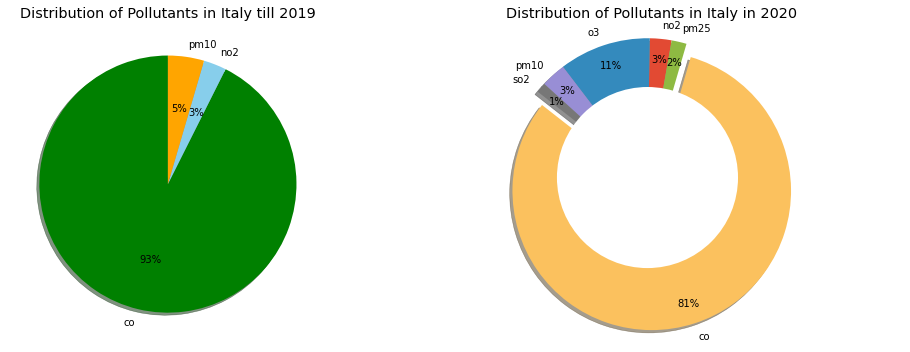

In [39]:
f, ax = plt.subplots(1,2, figsize = (14,5))
ax1, ax2 = ax.flatten()
ax1.pie(x = it_pop_19['avg_value'], labels = it_pop_19['pollutant'], shadow = True,
       autopct ='%1.0f%%', startangle = 90, colors = ['green','skyblue','orange'] )
ax1.set_title('Distribution of Pollutants in Italy till 2019')

ax2.set_title('Distribution of Pollutants in Italy in 2020')
ax2.pie(x = it_pop_20['avg_value'], labels = it_pop_20['pollutant'], shadow = True,
       autopct ='%1.0f%%', startangle = 80, pctdistance = 0.85, explode = (0,0,0,0,0.1,0))
centre_circle = plt.Circle((0,0),0.65,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.show()




## Pollutants in BA (Bosnia And Herzegovina)

In [40]:
## Pollutant in BA (Bosnia And Herzegovina)

query = """ 
select pollutant, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'BA' and extract(year from timestamp) < 2020
group by pollutant"""

ba_pop_19 = openaq.query_to_pandas(query)
print('Pollutant till 2019')
print(ba_pop_19)

print('\n')

query = """ 
select pollutant, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'BA' and extract(year from timestamp) = 2020
group by pollutant"""

ba_pop_20 = openaq.query_to_pandas(query)
print('Pollutant in 2020')
print(ba_pop_20)

Pollutant till 2019
  pollutant  avg_value
0       no2       27.0
1      pm10       61.0
2        co      437.0
3        o3       23.0
4       so2       27.0


Pollutant in 2020
  pollutant  avg_value
0      pm25        8.0
1        co     1427.0
2       no2       10.0
3        o3       10.0
4       so2       22.0


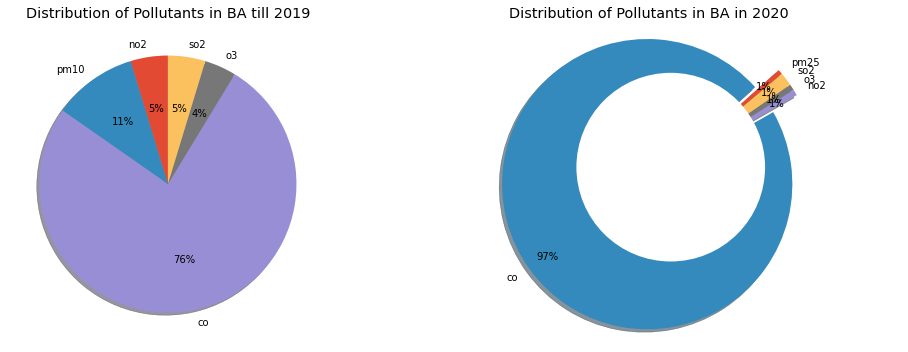

In [41]:
## Distribution of Pollutants in BA

f, ax = plt.subplots(1,2, figsize = (14,5))
ax1, ax2 = ax.flatten()
ax1.pie(x = ba_pop_19['avg_value'], labels = ba_pop_19['pollutant'], shadow = True,
       autopct ='%1.0f%%', startangle = 90)
ax1.set_title('Distribution of Pollutants in BA till 2019')

ax2.set_title('Distribution of Pollutants in BA in 2020')
ax2.pie(x = ba_pop_20['avg_value'], labels = ba_pop_20['pollutant'], shadow = True,
       autopct ='%1.0f%%', startangle = 40, pctdistance = 0.85, explode = (0,0.2,0,0,0))
centre_circle = plt.Circle((0,0),0.65,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.show()

In [42]:
query = """

select extract(year from timestamp) as year, latitude, longitude, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000 and 
extract(year from timestamp) <= 2020
group by year, latitude, longitude
"""

p1 = openaq.query_to_pandas(query)
p1.sort_values(by = 'year', inplace = True)
p1




,year,latitude,longitude,avg_value
5892,2007,5.533455,-0.212992,33.0
5893,2007,5.534919,-0.212406,76.0
5902,2007,5.640900,-0.169544,41.0
5900,2007,5.633557,-0.165187,17.0
5897,2007,5.570722,-0.212056,54.0
...,...,...,...,...
2689,2020,38.675800,16.098250,8.0
2688,2020,38.664580,16.080240,91.0
2687,2020,38.399860,16.070220,43.0
2707,2020,39.489630,16.386800,117.0



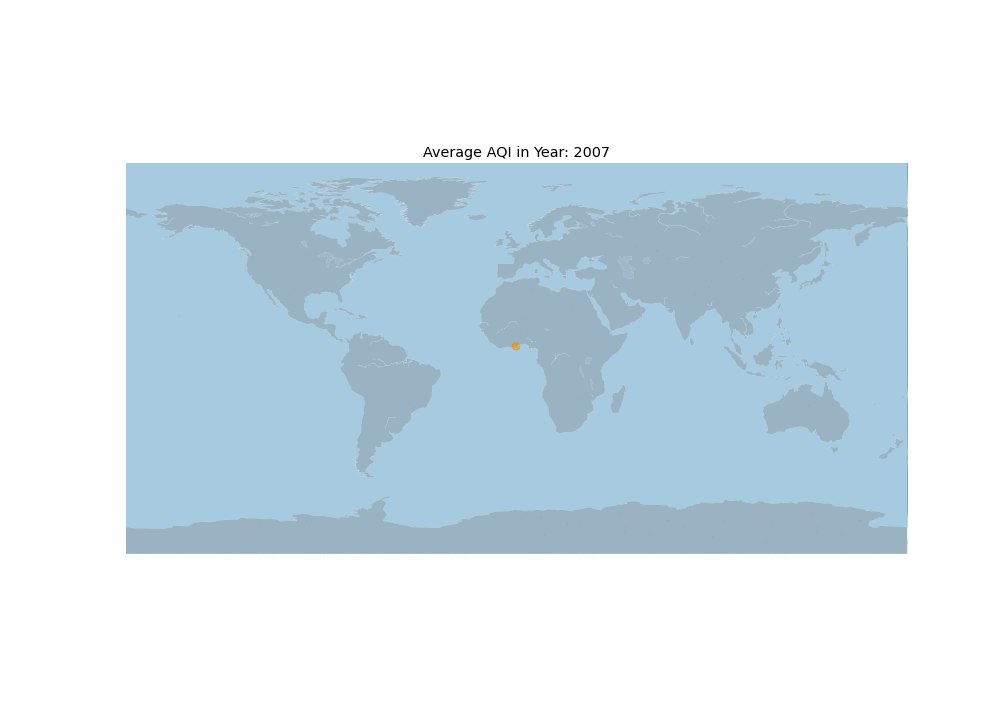

In [43]:
from matplotlib import animation,rc
import io
import base64
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(14,10))
plt.style.use('ggplot')

def animate(Year):
    ax = plt.axes()
    ax.clear()
    ax.set_title('Average AQI in Year: '+str(Year))
    m4 = Basemap(llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,projection='cyl')
    m4.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
    m4.fillcontinents(color='grey', alpha=0.3)
    m4.drawcoastlines(linewidth=0.1, color="white")
    m4.shadedrelief()
    
    lat_y = list(p1[p1['year'] == Year]['latitude'])
    lon_y = list(p1[p1['year'] == Year]['longitude'])
    lat,lon = m4(lat_y,lon_y) 
    avg = p1[p1['year'] == Year]['avg_value']
    m4.scatter(lon,lat,c = avg,lw=2, alpha=0.3,cmap='hot_r')
    
   
ani = animation.FuncAnimation(fig,animate,list(p1['year'].unique()), interval = 1500)    
ani.save('animation.gif', writer='imagemagick', fps=1)
plt.close(1)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [44]:
query = """
select pollutant, round(avg(value)) as avg_value_till_19
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000 and extract(year from timestamp) < 2020
group by pollutant"""

pop_19 = openaq.query_to_pandas(query)
pop_19

,pollutant,avg_value_till_19
0,co,697.0
1,no2,29.0
2,o3,59.0
3,pm25,30.0
4,so2,11.0
5,pm10,54.0
6,bc,1.0


In [45]:
query = """
select pollutant, round(avg(value)) as avg_value_20
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000 and extract(year from timestamp) = 2020
group by pollutant"""

pop_20 = openaq.query_to_pandas(query)
pop_20

,pollutant,avg_value_20
0,co,430.0
1,no2,13.0
2,o3,49.0
3,pm10,25.0
4,so2,13.0
5,pm25,14.0
6,bc,5.0


In [46]:
df= pd.merge(pop_19, pop_20, how ='inner', on ='pollutant')
df['perc_change'] = round((df['avg_value_till_19'] - df['avg_value_20'])*100/df['avg_value_till_19'])
df

,pollutant,avg_value_till_19,avg_value_20,perc_change
0,co,697.0,430.0,38.0
1,no2,29.0,13.0,55.0
2,o3,59.0,49.0,17.0
3,pm25,30.0,14.0,53.0
4,so2,11.0,13.0,-18.0
5,pm10,54.0,25.0,54.0
6,bc,1.0,5.0,-400.0


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

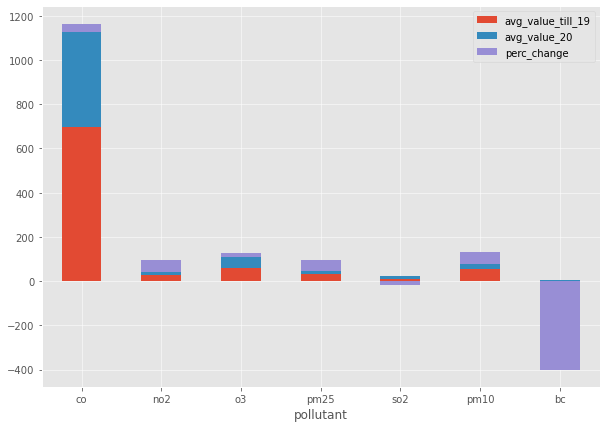

In [47]:
df.plot.bar(x ='pollutant', stacked = True, figsize = (10,7))
plt.xticks(rotation = 360)

This is my first attempt to Google Bigquery. If you have any recommendations or suggestions for improvement please do comment. I'll really appreciate it.